### Interpolation of FESOM data into HEALPix grid using CDO

In this script, we will:
- interpolate FESOM2 data to HEALPix grid using Climate Data Operators (CDO)
- define land masks for the surface and each depth level
- compare global averages on original mesh and HEALPix grid
- implement get_mask function from pyfesom2

If you would like to try to repeat examples from this notebook, you can download FESOM2 data and mesh. The data are about 1.5Gb in bzip2 archive.

Link
- https://swiftbrowser.dkrz.de/public/dkrz_c719fbc3-98ea-446c-8e01-356dac22ed90/PYFESOM2/

Also, you need griddes_nodes_IFS.nc (for variables on nodes (vertices)) and griddes_elements_IFS.nc (for variables on elements)

Links
- https://gitlab.awi.de/fesom/core2_old/-/raw/master/core2_old_griddes_elements_IFS.nc
- https://gitlab.awi.de/fesom/core2_old/-/raw/master/core2_old_griddes_nodes_IFS.nc



In [10]:
#data processing
import numpy as np
import pandas as pd
import healpy as hp
import xarray as xr
#cdo running
import subprocess
#visualisation
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.cm as cm
import matplotlib.pylab as plt
#get_mask function
import shapely.geometry
import shapely.vectorized
import json
import pkg_resources

### Data preprocessing

In order to define land masks for surface we will use coast variable from core2_old_griddes_nodes_IFS.nc and nod_area variable from fesom.mesh.diag.nc.

fesom_temp.nc file contains temperature data from temp.fesom.*.nc files

In [8]:
coord = xr.open_dataset('core2_old_griddes_nodes_IFS.nc')
mesh = xr.open_dataset('fesom.mesh.diag.nc')
data = xr.open_dataset('fesom_temp.nc')
data

<xarray.Dataset>
Dimensions:  (nz1: 47, time: 10, nod2: 126858)
Coordinates:
  * nz1      (nz1) float64 2.5 7.5 15.0 25.0 ... 5.525e+03 5.825e+03 6.125e+03
  * time     (time) datetime64[ns] 1948-12-30T23:15:00 ... 1957-12-31T23:15:00
Dimensions without coordinates: nod2
Data variables:
    temp     (time, nod2, nz1) float32 ...
Attributes: (12/19)
    FESOM_model:                         FESOM2
    FESOM_website:                       fesom.de
    FESOM_git_SHA:                       d01738a
    FESOM_MeshPath:                      /mnt/lustre01/work/ab0995/a270088/me...
    FESOM_mesh_representative_checksum:  96ef52281f7e327b221950bcd07cc1d8
    FESOM_ClimateDataPath:               /pool/data/AWICM/FESOM2/INITIAL/phc3.0/
    ...                                  ...
    FESOM_include_fleapyear:             0
    FESOM_use_floatice:                  0
    FESOM_whichEVP:                      0
    FESOM_evp_rheol_steps:               150
    FESOM_visc_option:                   5
    FESOM_w_split:                       0

In fesom, nz(nl) corresponds to interface levels and nz1(nl1) corresponds to the intermediate between interface levels.

The data lies on the nz1 coordinate, while nod_area lies on the interfaces. For nod_area we will use the values for the upper interface

In [5]:
depth_weights = mesh.nod_area.sel(nl=slice(0,47))


0 values in nod_area represent the land.

Combining it with the coast variable allows us to create a land mask for each depth level.

For CDO interpolation we need to combine our land mask, data and coordinates into one netcdf file.

In [14]:
def zero_weights(weights):
    return weights == 0

In [15]:
mask_w = zero_weights(depth_weights)
mask_w = mask_w*1
new_mask = mask_w.values + coord.coast.values
new_mask[new_mask == 2] = 1
mask_w.values = new_mask

In [16]:
land_mask = mask_w.to_dataset(name = "mask_land")
land_mask = land_mask.rename({
    'nl': 'nz1',
    'nod_n': 'nod2',
})
land_mask = land_mask.transpose('nod2','nz1')

In [17]:
latlon = coord[['grid_center_lon', 'grid_center_lat']]
latlon.grid_center_lon.attrs =  {'units': 'degrees', 'standard_name': 'longitude'}
latlon.grid_center_lat.attrs =  {'units': 'degrees', 'standard_name': 'latitude'}
latlon = latlon.rename({'grid_size': 'nod2'})

In [18]:
to_hp_data = xr.merge([latlon,land_mask,data])

In [19]:
to_hp_data.to_netcdf('temp_and_mask.nc')

### CDO interpolation
we wiil use subprocess package in order to run CDO in a loop

- remapnn, hpzZ - nearest neighbor on HEALPix grid, Z is the zoom level (from 0 to 9)
- setgrid - sets the grid to our source file
- last two files are input on FESOM grid and output file.

In [21]:
gridfile = 'core2_old_griddes_nodes_IFS.nc'
original_file = 'temp_and_mask.nc'
for z in range(0,10):
    output_file = f'temp_and_mask_hp{z}zoom.nc'

    command = [
        "cdo",
        f"-remapnn,hpz{z}",
        f"-setgrid,{gridfile}",
        f"{original_file}",
        f"{output_file}"
    ]

    # Execute the command
    subprocess.run(command)

cdo    remapnn: Nearest neighbor weights from unstructured (126858) to healpix (12) grid
cdo    remapnn: Nearest neighbor weights from unstructured (126858) to healpix (48) grid
cdo    remapnn: Nearest neighbor weights from unstructured (126858) to healpix (192) grid
cdo    remapnn: Nearest neighbor weights from unstructured (126858) to healpix (768) grid
cdo    remapnn: Nearest neighbor weights from unstructured (126858) to healpix (3072) grid
cdo    remapnn: Nearest neighbor weights from unstructured (126858) to healpix (12288) grid
cdo    remapnn: Nearest neighbor weights from unstructured (126858) to healpix (49152) grid
cdo    remapnn: Nearest neighbor weights from unstructured (126858) to healpix (196608) grid
cdo    remapnn: Nearest neighbor weights from unstructured (126858) to healpix (786432) grid
cdo    remapnn: Nearest neighbor weights from unstructured (126858) to healpix (3145728) grid


Let's take a look at the interpolated data. For visualisation we will use functions defined at the [FESOM_to_HEALPix notebook](https://github.com/FESOM/FESOM_examples/blob/main/healpix_example/FESOM_to_HEALPix.ipynb)

In [22]:
ds = xr.open_dataset('temp_and_mask_hp9zoom.nc')

We also need a function to mask the land

In [23]:
def ocean(ds,nz1):
    """
    Returns a boolean mask indicating ocean points based on the provided dataset and vertical level.

    Args:
        ds (xarray.Dataset): The dataset containing information about the ocean.
        nz1 (int): The vertical level to consider. If set to -1, the mask for all vertical levels is returned.

    Returns:
        xarray.DataArray: A boolean mask indicating ocean points. True for ocean points, False for land points.
    """
    if nz1 == -1:
        return ds.mask_land == 0
    else:
        return ds.mask_land.isel(nz1=nz1) == 0

In [24]:
def nnshow(var, nx=1000, ny=1000, ax=None, **kwargs):
    """
    Plots a variable on a Healpix.

    Args:
        var (array-like): Variable on Healpix coordinates (e.g., numpy array).
        nx (int, optional): Image resolution in the x-direction (default is 1000).
        ny (int, optional): Image resolution in the y-direction (default is 1000).
        ax (matplotlib.axes.Axes, optional): Axis to plot on. If not provided,
            the current axis will be used (default is None).
        **kwargs: Additional arguments to pass to the imshow function.
    """
    if ax is None:
        ax = plt.gca()

    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    xvals = np.linspace(xlims[0], xlims[1], nx)
    yvals = np.linspace(ylims[0], ylims[1], ny)
    xvals2, yvals2 = np.meshgrid(xvals, yvals)
    latlon = ccrs.PlateCarree().transform_points(
        ax.projection, xvals2, yvals2, np.zeros_like(xvals2)
    )
    valid = np.all(np.isfinite(latlon), axis=-1)
    points = latlon[valid].T
    pix = hp.ang2pix(
        hp.npix2nside(len(var)), theta=points[0], phi=points[1], nest=True, lonlat=True
    )
    res = np.full(latlon.shape[:-1], np.nan, dtype=var.dtype)
    res[valid] = var[pix]
    return ax.imshow(res, extent=xlims + ylims, origin="lower", **kwargs)

In [25]:
def worldmap(var,cbar,**kwargs):
    """
    Plot a variable on a Robinson projection world map.

    The function creates a Robinson projection world map using the provided variable
    'var'. 
    
    Args:
        var (array-like): The variable to be plotted on the world map.
        cbar (bool): A boolean flag to indicate whether to display the colorbar. If True,
            a colorbar will be shown; otherwise, no colorbar will be displayed.
        **kwargs: Additional keyword arguments to pass to the `nnshow` function.
    """
    projection = ccrs.Robinson(central_longitude=0)
    fig, ax = plt.subplots(
        figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
    )
    ax.set_global()

    nnshow(var, ax=ax, **kwargs)
    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    if cbar is not False:
        cbar = plt.colorbar(ax.get_images()[0], ax=ax, orientation='vertical', pad=0.05)
        try:
            cbar.set_label(var.attrs['long_name']+', '+var.attrs['units'])  # Set the label for the colorbar
        except:
            cbar.set_label()

In [26]:
def plot_healpix(data_healpix,
                 proj = 'mercator',
                 extent = None,
                 interactive = False,
                 cmap=cm.Spectral_r,
                 cbar = False,
                 vmin = None,vmax = None,
                 savefig = False,
                savepath = None):
    
    """
    Plots data on a Healpix grid with various customization options.

    The function takes data defined on a Healpix grid and visualizes it on a specified
    map projection. 
    Args:
        data_healpix (array-like): Data on a Healpix grid.
        proj (str, optional): The map projection to use. Supported options are 'mercator',
            'np' (North Polar Stereographic), and 'sp' (South Polar Stereographic).
            Default is 'mercator'.
        extent (list, optional): The extent of the plot specified as ([min_lon, max_lon,
            min_lat, max_lat]) in degrees. Default is None, which shows the global extent.
        interactive (bool, optional): If True, the plot is displayed interactively with
            widgets for zooming and panning. If False, a static image is displayed.
            Default is False.
        cmap (colormap, optional): The colormap to use for the plot. Default is 'Spectral_r'.
        cbar (bool, optional): If True, a colorbar is displayed. If False, no colorbar is shown.
            Default is False.
        vmin (float, optional): The lower limit for the color scale. If not provided, the
            minimum value in 'data_healpix' will be used.
        vmax (float, optional): The upper limit for the color scale. If not provided, the
            maximum value in 'data_healpix' will be used.
        savefig (bool, optional): If True, the plot is saved as an image. If False, the plot
            is not saved. Default is False.
        savepath (str, optional): The path to save the image file. Default is None, which
            saves the image in the current working directory.
    """
    
    if vmin is None:
        vmin = np.nanmin(data_healpix)
    if vmax is None:
        vmax = np.nanmax(data_healpix)
    if interactive == False:
        %matplotlib inline

        if extent == None:
            worldmap(data_healpix, cbar,cmap=cmap,vmin = vmin, vmax = vmax)
        else:
            if proj == 'mercator':
                projection = ccrs.Mercator(central_longitude=0)
            elif proj == 'np':
                projection = ccrs.NorthPolarStereo(central_longitude=0)
            elif proj == 'sp':
                 projection = ccrs.SouthPolarStereo(central_longitude=0)
            fig, ax = plt.subplots(
                figsize=(7, 5), subplot_kw={"projection": projection}, constrained_layout=True
            )
            ax.set_extent(extent, ccrs.PlateCarree())
            nnshow(data_healpix, ax=ax, cmap=cmap,vmin = vmin, vmax = vmax)
            ax.add_feature(cf.COASTLINE, linewidth=0.8)
            # Add a colorbar to the plot
            if cbar is not False:
                cbar = plt.colorbar(ax.get_images()[0], ax=ax, orientation='vertical', pad=0.05)
                try:
                    cbar.set_label(data_healpix.attrs['long_name']+', '+data_healpix.attrs['units'])  # Set the label for the colorbar
                except:
                    cbar.set_label()
    else:
        %matplotlib widget
        hp.mollzoom(data_healpix,
                    flip="geo",
                    cmap =cmap,
                    min = vmin, max = vmax,
                    title=data.attrs['long_name']+', '+data.attrs['units'])
    if savefig == True:
        filename = f'{variable_name}_'+sel_time+'_'+sel_depth
        if extent is not None:
            filename = filename+f'_{extent[0]}_{extent[1]}_{extent[2]}_{extent[3]}'
        if savepath is not None:
            filename = savepath + '/' + filename
        plt.savefig(filename+'.jpg',dpi = 300, format = 'jpg')
    plt.show()

Global ocean temperature for the surface

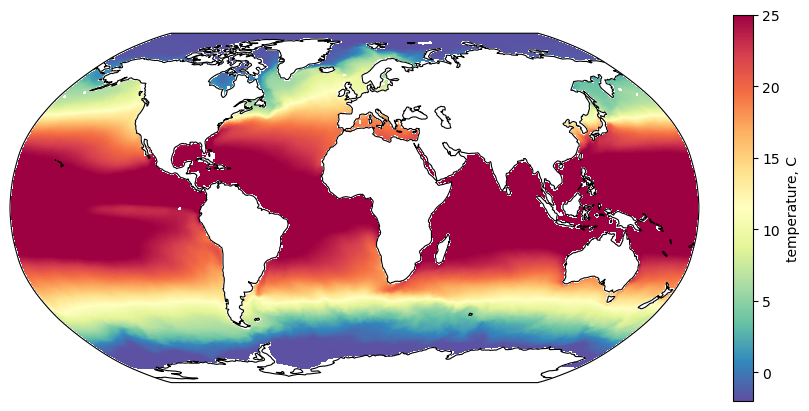

In [28]:
depth = 0
time = 0
data_healpix = ds.temp.isel(time=time,nz1=depth).where(ocean(ds,depth))
plot_healpix(data_healpix, cbar = True,vmin = -2, vmax = 25)

At the 25th depth level

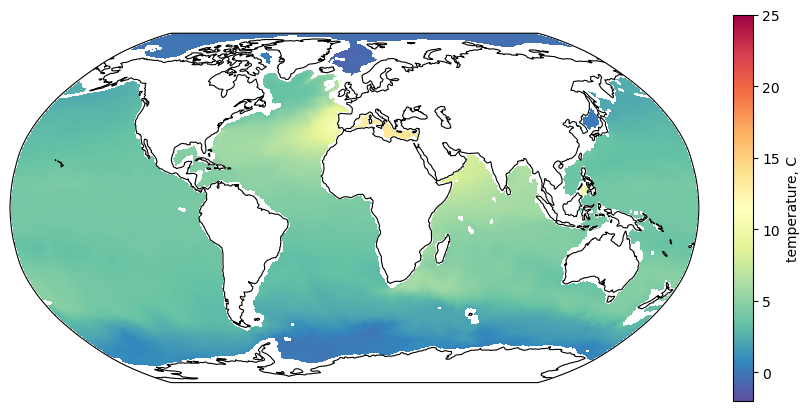

In [30]:
depth = 25
time = 0
data_healpix = ds.temp.isel(time=time,nz1=depth).where(ocean(ds,depth))
plot_healpix(data_healpix, cbar = True,vmin = -2, vmax = 25)

### Global average 

First, let's calculate the global average on the original mesh

In [33]:
weights = mesh.nod_area
weights = weights.isel(nl=slice(0,47))
weights = weights.rename({'nod_n': 'nod2','nl':'nz1'})

In [34]:
mean_orig_surface = data.temp.isel(nz1=0).weighted(weights.isel(nz1=0)).mean('nod2')

In [35]:
mean_orig_all_lvls = data.temp.isel(time=0).weighted(weights).mean('nod2')

Now, we calculate the global average for the surface on HEALPix grid on 5 (5-9) zoom levels and compare it with the average on the original mesh

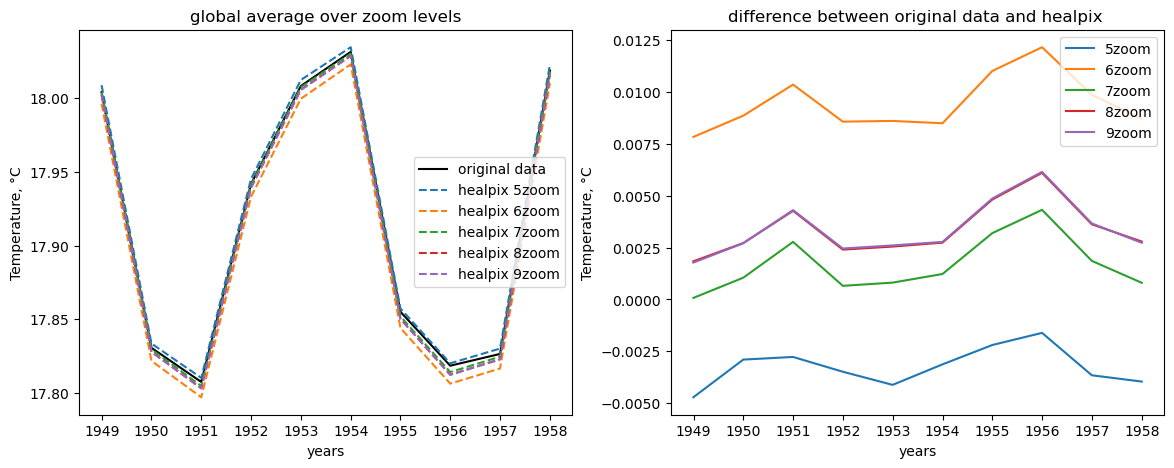

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].plot(mean_orig_surface.time,mean_orig_surface, label = 'original data',color = 'k')
for z in range(5,10):
    ds = xr.open_dataset(f'temp_and_mask_hp{z}zoom.nc')
    temp_hp = ds.temp.isel(nz1=0)
    mean_healpix_surface = temp_hp.weighted((ocean(ds,0))).mean("cells")
    ax[0].plot(mean_orig_surface.time,mean_healpix_surface,'--', label = f'healpix {z}zoom')
    ax[0].set_xlabel('years')
    ax[0].set_ylabel('Temperature, °C')
    ax[0].legend()
    ax[1].plot(mean_orig_surface.time,mean_orig_surface-mean_healpix_surface, label = f'{z}zoom')
    ax[1].set_xlabel('years')
    ax[1].set_ylabel('Temperature, °C')
    ax[1].legend()
ax[0].set_title('global average over zoom levels')
ax[1].set_title('difference between original data and healpix ')

plt.show()

Let's take a look at the global averages on each depth levels for one year

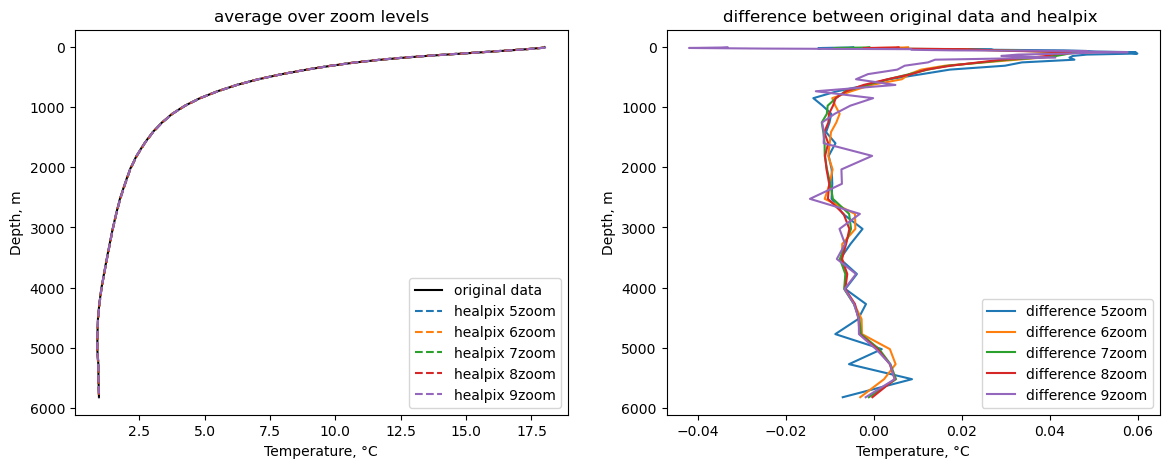

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(mean_orig_all_lvls,mean_orig_all_lvls.nz1, label = 'original data',color = 'k')
for z in range(5,10):
    ds = xr.open_dataset(f'temp_and_mask_hp{z}zoom.nc')
    temp_hp = ds.temp.isel(time=0)
    mean_healpix_all_lvls = temp_hp.weighted((ocean(ds,-1))).mean("cells")
    ax[0].plot(mean_healpix_all_lvls,mean_orig_all_lvls.nz1,'--', label = f'healpix {z}zoom')
    ax[0].set_xlabel('Temperature, °C')
    ax[0].set_ylabel('Depth, m')
    ax[0].legend()
    ax[0].invert_yaxis()

    ax[1].plot(mean_orig_all_lvls-mean_healpix_all_lvls,mean_orig_all_lvls.nz1, label = f'difference {z}zoom')
    ax[1].set_xlabel('Temperature, °C')
    ax[1].set_ylabel('Depth, m')
    ax[1].legend()
    ax[1].invert_yaxis()
ax[0].set_title('average over zoom levels')
ax[1].set_title('difference between original data and healpix ')
plt.show()

### get_mask function from pyfesom2

In order to do calculations for specific regions on HEALPix grid, we can implement get_mask function from pyfesom2 package 

In [38]:
def mask_from_file(filename, name, lon,lat):
    """Create mask from geojson file

    Parameters:
    ----------=
        filename: str
            path to the geojson file.
            File should have several features
        name: str
            name of the feature, that will be our mask
        mesh: mesh object
            pyfesom2 mesh object

    Returns:
    --------
        mask: numpy array
            boolean vector of the shape of 2D data.

    """
    with open(filename) as f:
        features = json.load(f)["features"]
    for feature in features:
        if feature["properties"]["name"] == name:
            geom = shapely.geometry.shape(feature["geometry"])
            mask = shapely.vectorized.contains(geom, lon,lat)
    return mask

In [39]:
def get_mask(lon,lat, region):
    """Return mask.

    Parameters:
    -----------
    mesh: mesh object
        pyfesom2 mesh object
    name: str
        name of the region.
        Available regions:
            Ocean Basins:
                "Atlantic_Basin"
                "Pacific_Basin"
                "Indian_Basin"
                "Arctic_Basin"
                "Southern_Ocean_Basin"
                "Mediterranean_Basin"
                "Global Ocean"
                "Global Ocean 65N to 65S"
                "Global Ocean 15S to 15N"
            MOC Basins:
                "Atlantic_MOC"
                "IndoPacific_MOC"
                "Pacific_MOC"
                "Indian_MOC"
            Nino Regions:
                "Nino 3.4"
                "Nino 3"
                "Nino 4"
            Arctic Ocean regions:
                "Amerasian basin"
                "Eurasian basin"
    Returns:
    --------
        mask: numpy array
            boolean or integer (for AO regions) vector of the shape of 2D data.
    """

    MOCBasins = ["Atlantic_MOC", "IndoPacific_MOC", "Pacific_MOC", "Indian_MOC"]
    NinoRegions = ["Nino 3.4", "Nino 3", "Nino 4"]
    oceanBasins = [
        "Atlantic_Basin",
        "Pacific_Basin",
        "Indian_Basin",
        "Arctic_Basin",
        "Southern_Ocean_Basin",
        "Mediterranean_Basin",
        "Global Ocean",
        "Global Ocean 65N to 65S",
        "Global Ocean 15S to 15N",
    ]

    if region == "Amerasian basin":
        ind_AB1 = np.where((lon >= -100) & (lon< -80) & (lat >= 80))
        ind_AB2 = np.where((lon>= -180) & (lon< -100) & (lat > 66))
        ind_AB3 = np.where((lon < 180) & (lon > 140) & (lat > 66))

        mask = np.hstack((ind_AB1[0], ind_AB2[0], ind_AB3[0]))

    elif region == "Eurasian basin":
        ind_EB1 = np.where((lon > -80) & (lon < 100) & (lat> 80))
        ind_EB2 = np.where((lon > 100) & (lon < 140) & (lat > 66))

        mask = np.hstack((ind_EB1[0], ind_EB2[0]))

    elif region in MOCBasins:
        filename = pkg_resources.resource_filename(
            __name__, "MOCBasins.geojson"
        )
        mask = mask_from_file(filename, region, lon,lat)

    elif region in NinoRegions:
        filename = pkg_resources.resource_filename(
            __name__, "NinoRegions.geojson"
        )
        mask = mask_from_file(filename, region, lon,lat)

    elif region in oceanBasins:
        filename = pkg_resources.resource_filename(
            __name__, "oceanBasins.geojson"
        )
        mask = mask_from_file(filename, region, lon,lat)

    else:
        raise ValueError(f"Name {region} is not in the get_mask function.")

    return mask

In [40]:
lon_healpy = np.where(ds.grid_center_lon.values<180, ds.grid_center_lon.values, ds.grid_center_lon.values-360)
lat_healpy = ds.grid_center_lat.values

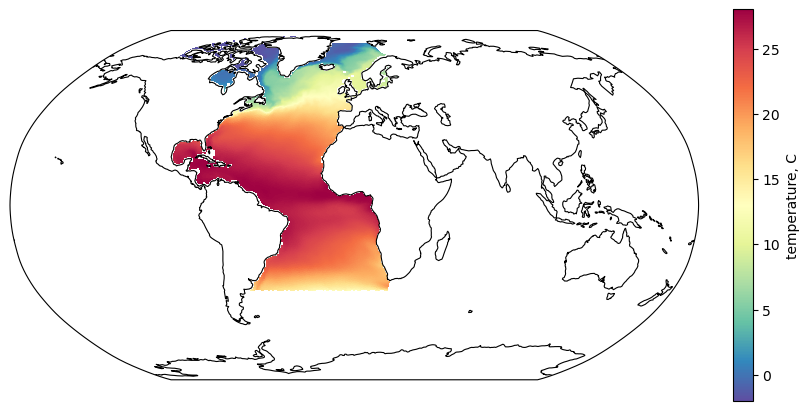

In [43]:
mask1 = get_mask(lon_healpy,lat_healpy, "Atlantic_Basin")
depth = 0
time = 5
data_healpix = ds.temp.isel(time=time,nz1=depth).where(ocean(ds,depth)).where(mask1)
plot_healpix(data_healpix,cbar = True,vmin = -2, vmax = 28)


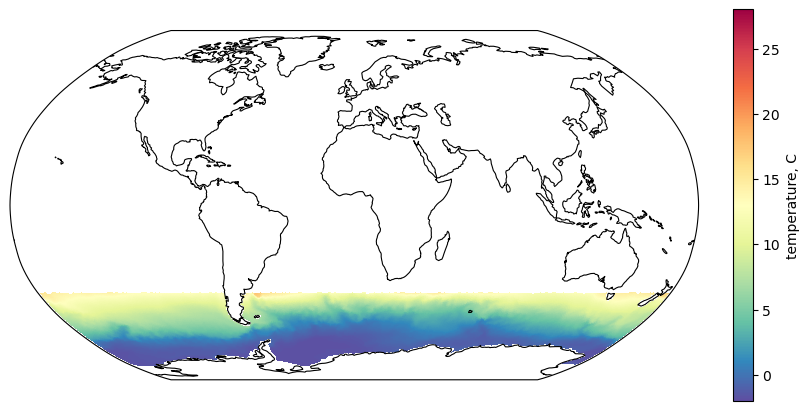

In [44]:
mask2 = get_mask(lon_healpy,lat_healpy, "Southern_Ocean_Basin")
depth = 0
time = 5
data_healpix = ds.temp.isel(time=time,nz1=depth).where(ocean(ds,depth)).where(mask2)
plot_healpix(data_healpix,cbar = True,vmin = -2, vmax = 28)

We aslo can combine different masks

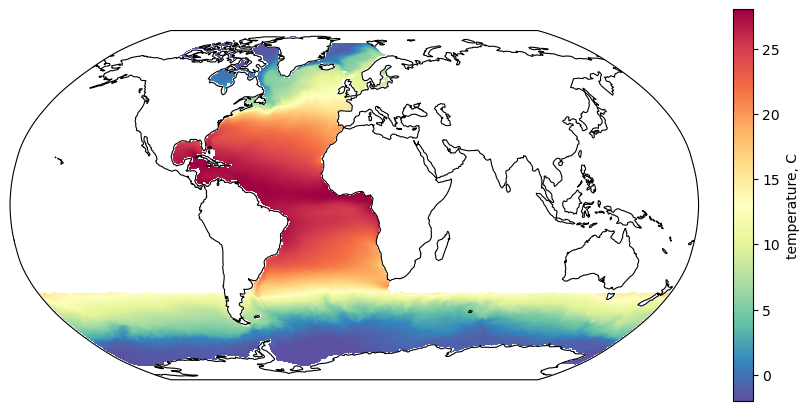

In [45]:
mask3 = mask1|mask2
depth = 0
time = 5
data_healpix = ds.temp.isel(time=time,nz1=depth).where(ocean(ds,depth)).where(mask3)
plot_healpix(data_healpix,cbar = True,vmin = -2, vmax = 28)